In [1]:
%pip install transformers datasets scikit-learn --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import platform
print(f"Python version: {sys.version}")
print(f"Architecture: {platform.architecture()[0]}")

Python version: 3.11.7 (main, Apr 12 2025, 17:10:17) [Clang 16.0.0 (clang-1600.0.26.6)]
Architecture: 64bit


In [3]:
%pip install "numpy<2.0"


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install torch accelerate matplotlib --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
from transformers import DistilBertConfig, DistilBertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score

# ==========================================
# 0. GLOBAL SETUP (Run once to load data)
# ==========================================
print("Loading tokenizer and dataset...")

# We use DistilBERT tokenizer as the base
TOKENIZER = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# We use GLUE/SST-2 (Sentiment Analysis) as our proxy task because it's fast and standard
DATASET = load_dataset("glue", "sst2")

def tokenize_function(examples):
    # Truncate to max_length=64 to speed up training (proxy task optimization)
    return TOKENIZER(examples["sentence"], padding="max_length", truncation=True, max_length=64)

# Tokenize the dataset once
TOKENIZED_DATASETS = DATASET.map(tokenize_function, batched=True)

# Reduce dataset size for the "Proxy Task" (Budget constraint)
# We only use a small subset (e.g., 1000 samples) to simulate a low-resource environment
SMALL_TRAIN_DATASET = TOKENIZED_DATASETS["train"].shuffle(seed=42).select(range(1000))
SMALL_EVAL_DATASET = TOKENIZED_DATASETS["validation"].shuffle(seed=42).select(range(500))

def compute_metrics(eval_pred):
    """Simple accuracy metric for evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

print("Setup complete. Ready for Evolutionary Search.")



/Users/macbookair/Documents/ESILV/A4/AI_Algorithms/Projet/venv_ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading tokenizer and dataset...
Setup complete. Ready for Evolutionary Search.


In [6]:
# ==========================================
# 0. BETTER SETUP (more data)
# ==========================================
#
# 4000 exemples shows real convergence yet no to many time (we want to sleep).
MEDIUM_TRAIN_DATASET = TOKENIZED_DATASETS["train"].shuffle(seed=42).select(range(4000))
MEDIUM_EVAL_DATASET = TOKENIZED_DATASETS["validation"].shuffle(seed=42).select(range(500))

In [7]:

# ==========================================
# 2. UPDATED EVALUATOR CLASS
# ==========================================

class Evaluator:
    def __init__(self, mode="TOY"):
        self.mode = mode

    def evaluate(self, genome):
        if self.mode == "TOY":
            return self._evaluate_toy(genome)
        else:
            return self._evaluate_real(genome)

    def _evaluate_toy(self, genome):
        """
        SIMULATION: Purely mathematical function to test the GA logic.
        """
        # Simulated cost (proxy for FLOPs)
        cost = (genome.gene["num_hidden_layers"] * genome.gene["hidden_size"])
        # Simulated accuracy with noise
        accuracy = np.log(cost) * 10 + np.random.uniform(-2, 2)

        normalized_acc = min(95, max(50, accuracy))
        return (normalized_acc, cost)

    def _evaluate_real(self, genome):
        """
        REASONABLE VERSION (~10-15 mins per model):
        Trains for 400 steps (approx 1 epoch on the reduced dataset).
        This provides a much cleaner signal to distinguish good architectures
        from bad ones, effectively implementing 'Low-Fidelity Estimation'.
        """
        print(f"\n[Real Eval] Testing Architecture: {genome.gene}")

        # 1. Dynamic Configuration
        # We create a DistilBERT config from the genome parameters
        config = DistilBertConfig(
            vocab_size=30522,
            n_layers=genome.gene["num_hidden_layers"],
            n_heads=genome.gene["num_attention_heads"],
            dim=genome.gene["hidden_size"],
            hidden_dim=genome.gene["intermediate_size"],
            num_labels=2,
            dropout=0.1,
            attention_dropout=0.1
        )

        # 2. Initialize Model from Scratch (Random Weights)
        model = DistilBertForSequenceClassification(config)
        num_params = model.num_parameters()
        print(f"  > Model Size: {num_params / 1e6:.2f} Million parameters")

        # 3. Training Arguments (Mid-Range Budget)
        training_args = TrainingArguments(
            output_dir="./tmp_nas_checkpoints",
            learning_rate=5e-5,              # Standard learning rate
            per_device_train_batch_size=16,  # Smaller batch size to save VRAM with larger models
            per_device_eval_batch_size=64,
            max_steps=400,                   # <--- KEY TO CHANGE: here 400 steps for better estimation
            warmup_steps=50,                 # Warmup to stabilize early training
            eval_strategy="steps",
            eval_steps=100,                  # Evaluate every 100 steps to monitor the curve
            save_strategy="no",              # Do not save checkpoints (saves disk space)
            logging_steps=50,
            report_to="none",                # Disable external logging tools
            use_cpu=False if torch.cuda.is_available() else True
        )

        # 4. Trainer Initialization
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=MEDIUM_TRAIN_DATASET, # Use the "Medium" dataset (4k samples)
            eval_dataset=MEDIUM_EVAL_DATASET,
            compute_metrics=compute_metrics,
        )

        # 5. Start Training
        trainer.train()

        # 6. Final Evaluation
        eval_result = trainer.evaluate()
        accuracy = eval_result["eval_accuracy"] * 100

        print(f"  > Result: Accuracy={accuracy:.2f}% | Params={num_params}")

        # 7. Memory Cleanup
        del model
        del trainer
        torch.cuda.empty_cache()

        return (accuracy, num_params)

In [8]:
import random

# ==========================================
# 3. SEARCH SPACE & GENOME DEFINITION
# ==========================================
# Defines the boundaries of our exploration.
# We modify architectural parameters that impact both performance and size.
SEARCH_SPACE = {
    "num_hidden_layers": [2, 4, 6],       # Depth: fewer layers = faster but less capable
    "num_attention_heads": [4, 8, 12],    # Width: needs to be compatible with hidden_size
    "hidden_size": [256, 512, 768],       # Representation size
    "intermediate_size": [512, 1024, 2048]# FFN size: usually 4x hidden_size
}


class Genome:
    """
    Represents a candidate architecture.
    """
    def __init__(self, gene=None):
        # Initialisation aléatoire
        self.gene = gene if gene else {k: random.choice(v) for k, v in SEARCH_SPACE.items()}
        self.fitness = None

        # SÉCURITÉ IMMÉDIATE : On répare l'ADN dès la naissance
        self._ensure_validity()

    def mutate(self):
        """Mutation aléatoire d'un gène"""
        mutation_key = random.choice(list(SEARCH_SPACE.keys()))
        self.gene[mutation_key] = random.choice(SEARCH_SPACE[mutation_key])

        # On répare après mutation aussi
        self._ensure_validity()
        self.fitness = None

    def _ensure_validity(self):
        """
        Force l'architecture à être mathématiquement valide pour DistilBERT.
        Règle : hidden_size doit être divisible par num_attention_heads.
        """
        # Si ce n'est pas divisible
        if self.gene["hidden_size"] % self.gene["num_attention_heads"] != 0:
            # Solution simple : On force une taille cachée compatible
            # On prend un multiple standard (ex: 64 * nombre de têtes)
            # Ex: si 12 heads, on force hidden_size à 768 (car 12*64=768)
            new_hidden = self.gene["num_attention_heads"] * 64

            # On vérifie si cette nouvelle taille est dans notre SEARCH_SPACE, sinon on prend la plus proche
            if new_hidden not in SEARCH_SPACE["hidden_size"]:
                 # Fallback : on change le nombre de têtes pour qu'il colle à la taille cachée actuelle
                 # On cherche les diviseurs de hidden_size dans les choix possibles de heads
                 valid_heads = [h for h in SEARCH_SPACE["num_attention_heads"] if self.gene["hidden_size"] % h == 0]
                 if valid_heads:
                     self.gene["num_attention_heads"] = random.choice(valid_heads)
                 else:
                     # Cas extrême : on force des valeurs sûres par défaut
                     self.gene["hidden_size"] = 768
                     self.gene["num_attention_heads"] = 12
            else:
                self.gene["hidden_size"] = new_hidden

# ==========================================
# 4. EVOLUTIONARY LOOP
# ==========================================
def run_evolution(generations=3, population_size=4, mode="TOY"):
    """
    Main NAS loop implementing a simple Genetic Algorithm.
    """
    evaluator = Evaluator(mode=mode)

    # 1. Initialize Population
    population = [Genome() for _ in range(population_size)]

    print(f"\n--- Starting Evolutionary NAS (Mode: {mode}) ---")
    print(f"Population: {population_size} | Generations: {generations}")

    for gen in range(generations):
        print(f"\n=== GENERATION {gen+1}/{generations} ===")

        # 2. Evaluation Step
        for i, individual in enumerate(population):
            if not individual.fitness:
                print(f"  > Evaluating Indiv {i+1}/{len(population)}...")
                individual.fitness = evaluator.evaluate(individual)

        # 3. Selection Step (Ranking)
        # We sort primarily by Accuracy (fitness[0]).
        # In a real LEMONADE implementation, we would use Pareto sorting here.
        population.sort(key=lambda x: x.fitness[0], reverse=True)

        best = population[0]
        print(f"  [Gen {gen+1} Best] Acc: {best.fitness[0]:.2f}% | Params: {best.fitness[1]/1e6:.2f}M")
        print(f"  [Gen {gen+1} Arch] {best.gene}")

        # Stop here if it's the last generation
        if gen == generations - 1:
            break

        # 4. Reproduction Step (Elitism + Mutation)
        # Keep top 50% parents
        num_parents = population_size // 2
        survivors = population[:num_parents]

        children = []
        while len(children) < (population_size - num_parents):
            # Pick a parent randomly among survivors
            parent = random.choice(survivors)
            # Clone it
            child = Genome(parent.gene.copy())
            # Mutate it
            child.mutate()
            children.append(child)

        # Create new population
        population = survivors + children

    print("\n--- Search Complete ---")
    return population[0]

def run_evolution(generations=3, population_size=4, mode="TOY"):
    """
    Version améliorée qui retourne l'historique complet pour le plotting automatique.
    """
    evaluator = Evaluator(mode=mode)
    # Initialize Population
    population = [Genome() for _ in range(population_size)]
    
    # Liste pour stocker tous les résultats : (Generation, Params, Accuracy, Config)
    history = [] 

    print(f"\n--- Starting Evolutionary NAS (Mode: {mode}) ---")
    print(f"Population: {population_size} | Generations: {generations}")

    for gen in range(generations):
        print(f"\n=== GENERATION {gen+1}/{generations} ===")
        
        # 1. Evaluation
        for i, individual in enumerate(population):
            if not individual.fitness:
                print(f"  > Evaluating Indiv {i+1}/{len(population)}...")
                # L'evaluator retourne (Accuracy, Params_count)
                acc, params = evaluator.evaluate(individual)
                individual.fitness = (acc, params)
                
                # ON SAUVEGARDE LE RESULTAT ICI
                history.append({
                    'generation': gen + 1,
                    'params_M': params / 1e6,  # Convertir en Millions
                    'accuracy': acc,
                    'config': individual.gene
                })

        # 2. Selection (Ranking)
        population.sort(key=lambda x: x.fitness[0], reverse=True)
        
        best = population[0]
        print(f"  [Gen {gen+1} Best] Acc: {best.fitness[0]:.2f}% | Params: {best.fitness[1]/1e6:.2f}M")

        if gen == generations - 1:
            break

        # 3. Reproduction
        num_parents = population_size // 2
        survivors = population[:num_parents]
        children = []
        while len(children) < (population_size - num_parents):
            parent = random.choice(survivors)
            child = Genome(parent.gene.copy())
            child.mutate()
            children.append(child)
        
        population = survivors + children

    print("\n--- Search Complete ---")
    # On retourne LE MEILLEUR modèle ET L'HISTORIQUE complet
    return population[0], history

In [9]:
# Launch the evolution in REAL mode
# Warning: This will train actual neural networks (proxy task).
# Expect ~1-2 minutes per individual depending on GPU.
best_model = run_evolution(generations=4, population_size=5, mode="REAL")


--- Starting Evolutionary NAS (Mode: REAL) ---
Population: 5 | Generations: 4

=== GENERATION 1/4 ===
  > Evaluating Indiv 1/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 2, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 512}
  > Model Size: 30.73 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.693700,0.704854,0.466000
200,0.672800,0.674294,0.542000
300,0.574400,0.627011,0.658000
400,0.531500,0.604556,0.686000


  > Result: Accuracy=68.60% | Params=30734082
  > Evaluating Indiv 2/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 4, 'num_attention_heads': 8, 'hidden_size': 512, 'intermediate_size': 2048}
  > Model Size: 28.76 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.695400,0.695266,0.478000
200,0.670000,0.685793,0.532000
300,0.559100,0.613499,0.674000
400,0.490100,0.591044,0.680000


  > Result: Accuracy=68.00% | Params=28763650
  > Evaluating Indiv 3/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 2, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 2048}
  > Model Size: 35.46 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.695000,0.724249,0.478000
200,0.676700,0.687820,0.530000
300,0.589300,0.635909,0.614000
400,0.523700,0.602606,0.670000


  > Result: Accuracy=67.00% | Params=35455746
  > Evaluating Indiv 4/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 2, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 32.31 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.693900,0.707488,0.466000
200,0.674800,0.684662,0.532000
300,0.581200,0.634067,0.656000
400,0.532100,0.609117,0.678000


  > Result: Accuracy=67.80% | Params=32307970
  > Evaluating Indiv 5/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 4, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 40.19 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.697300,0.757063,0.478000
200,0.660600,0.722163,0.540000
300,0.520300,0.589244,0.682000
400,0.451300,0.566847,0.708000


  > Result: Accuracy=70.80% | Params=40188162
  [Gen 1 Best] Acc: 70.80% | Params: 40.19M
  [Gen 1 Arch] {'num_hidden_layers': 4, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}

=== GENERATION 2/4 ===
  > Evaluating Indiv 3/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 6, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 48.07 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.700600,0.776545,0.476000
200,0.656000,0.696329,0.544000
300,0.485400,0.569146,0.684000
400,0.399900,0.555689,0.722000


  > Result: Accuracy=72.20% | Params=48068354
  > Evaluating Indiv 4/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 2, 'num_attention_heads': 4, 'hidden_size': 768, 'intermediate_size': 512}
  > Model Size: 30.73 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.699200,0.707612,0.468000
200,0.668200,0.673935,0.554000
300,0.578200,0.629187,0.628000
400,0.558700,0.606718,0.682000


  > Result: Accuracy=68.20% | Params=30734082
  > Evaluating Indiv 5/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 6, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 48.07 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.699300,0.723434,0.476000
200,0.665600,0.696194,0.544000
300,0.493000,0.570867,0.700000
400,0.444600,0.556220,0.720000


  > Result: Accuracy=72.00% | Params=48068354
  [Gen 2 Best] Acc: 72.20% | Params: 48.07M
  [Gen 2 Arch] {'num_hidden_layers': 6, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}

=== GENERATION 3/4 ===
  > Evaluating Indiv 3/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 6, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 48.07 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.705300,0.771593,0.478000
200,0.655700,0.692524,0.548000
300,0.484500,0.588036,0.680000
400,0.398800,0.570806,0.718000


  > Result: Accuracy=71.80% | Params=48068354
  > Evaluating Indiv 4/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 6, 'num_attention_heads': 4, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 48.07 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.709700,0.770927,0.478000
200,0.658900,0.695438,0.550000
300,0.475200,0.587331,0.678000
400,0.395500,0.569547,0.718000


  > Result: Accuracy=71.80% | Params=48068354
  > Evaluating Indiv 5/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 6, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 48.07 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.705300,0.771593,0.478000
200,0.655700,0.692524,0.548000
300,0.484500,0.588036,0.680000
400,0.398800,0.570806,0.718000


  > Result: Accuracy=71.80% | Params=48068354
  [Gen 3 Best] Acc: 72.20% | Params: 48.07M
  [Gen 3 Arch] {'num_hidden_layers': 6, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}

=== GENERATION 4/4 ===
  > Evaluating Indiv 3/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 6, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 48.07 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.705300,0.771593,0.478000
200,0.655700,0.692524,0.548000
300,0.484500,0.588036,0.680000
400,0.398800,0.570806,0.718000


  > Result: Accuracy=71.80% | Params=48068354
  > Evaluating Indiv 4/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 6, 'num_attention_heads': 4, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 48.07 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.709700,0.770927,0.478000
200,0.658900,0.695438,0.550000
300,0.475200,0.587331,0.678000
400,0.395500,0.569547,0.718000


  > Result: Accuracy=71.80% | Params=48068354
  > Evaluating Indiv 5/5...

[Real Eval] Testing Architecture: {'num_hidden_layers': 6, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}
  > Model Size: 48.07 Million parameters


Step,Training Loss,Validation Loss,Accuracy
100,0.705300,0.771593,0.478000
200,0.655700,0.692524,0.548000
300,0.484500,0.588036,0.680000
400,0.398800,0.570806,0.718000


  > Result: Accuracy=71.80% | Params=48068354
  [Gen 4 Best] Acc: 72.20% | Params: 48.07M
  [Gen 4 Arch] {'num_hidden_layers': 6, 'num_attention_heads': 12, 'hidden_size': 768, 'intermediate_size': 1024}

--- Search Complete ---


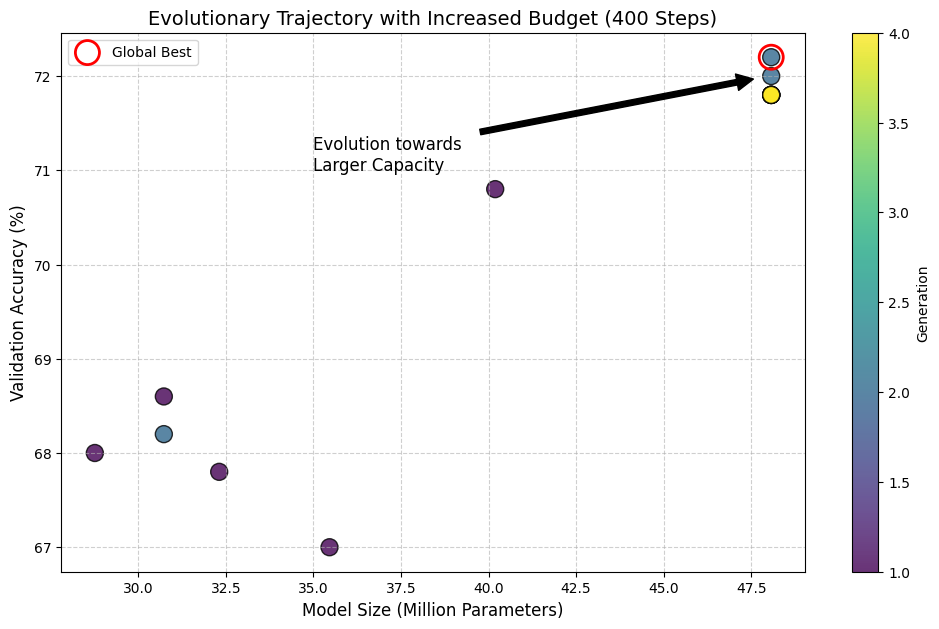

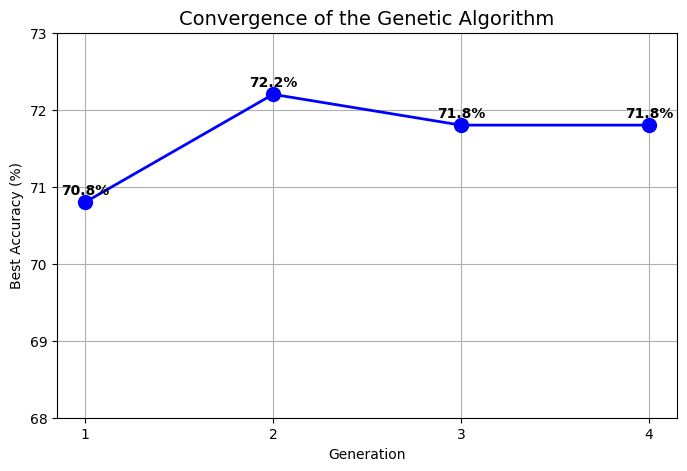

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted manually from your log output (400 Steps run)
# Format: (Generation, Params_Millions, Accuracy_Percent)
data = [
    # === GEN 1 (Exploration) ===
    (1, 30.73, 68.60),
    (1, 28.76, 68.00),
    (1, 35.46, 67.00),
    (1, 32.31, 67.80),
    (1, 40.19, 70.80), # Gen 1 Best
    
    # === GEN 2 (Optimization) ===
    (2, 48.07, 72.20), # Gen 2 Best (New Peak)
    (2, 30.73, 68.20),
    (2, 48.07, 72.00),
    
    # === GEN 3 (Convergence) ===
    (3, 48.07, 71.80),
    (3, 48.07, 71.80),
    (3, 48.07, 71.80),
    
    # === GEN 4 (Stagnation/Stability) ===
    (4, 48.07, 71.80),
    (4, 48.07, 71.80),
    (4, 48.07, 71.80)
]

# Separate data for plotting
generations = [d[0] for d in data]
params = [d[1] for d in data]
accs = [d[2] for d in data]

# --- PLOT 1: Search Landscape (Size vs Accuracy) ---
plt.figure(figsize=(12, 7))

# Create a scatter plot with color mapping based on generation
scatter = plt.scatter(params, accs, c=generations, cmap='viridis', s=150, alpha=0.8, edgecolors='k')

# Add a color bar to indicate generations
cbar = plt.colorbar(scatter)
cbar.set_label('Generation')

# Highlight the absolute best model
best_idx = np.argmax(accs)
plt.scatter(params[best_idx], accs[best_idx], s=300, facecolors='none', edgecolors='red', linewidth=2, label='Global Best')

# Arrows to show the trend
plt.annotate('Evolution towards\nLarger Capacity', 
             xy=(48, 72), xytext=(35, 71),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12)

plt.xlabel('Model Size (Million Parameters)', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.title('Evolutionary Trajectory with Increased Budget (400 Steps)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# --- PLOT 2: Best Accuracy per Generation ---
gen_best = {}
for g, p, a in data:
    if g not in gen_best:
        gen_best[g] = a
    else:
        gen_best[g] = max(gen_best[g], a)

gens = list(gen_best.keys())
best_accs = list(gen_best.values())

plt.figure(figsize=(8, 5))
plt.plot(gens, best_accs, marker='o', linestyle='-', color='b', linewidth=2, markersize=10)
plt.xlabel('Generation')
plt.ylabel('Best Accuracy (%)')
plt.title('Convergence of the Genetic Algorithm', fontsize=14)
plt.grid(True)
plt.xticks([1, 2, 3, 4])
plt.ylim(68, 73)

for x, y in zip(gens, best_accs):
    plt.text(x, y + 0.1, f"{y:.1f}%", ha='center', fontweight='bold')

plt.show()

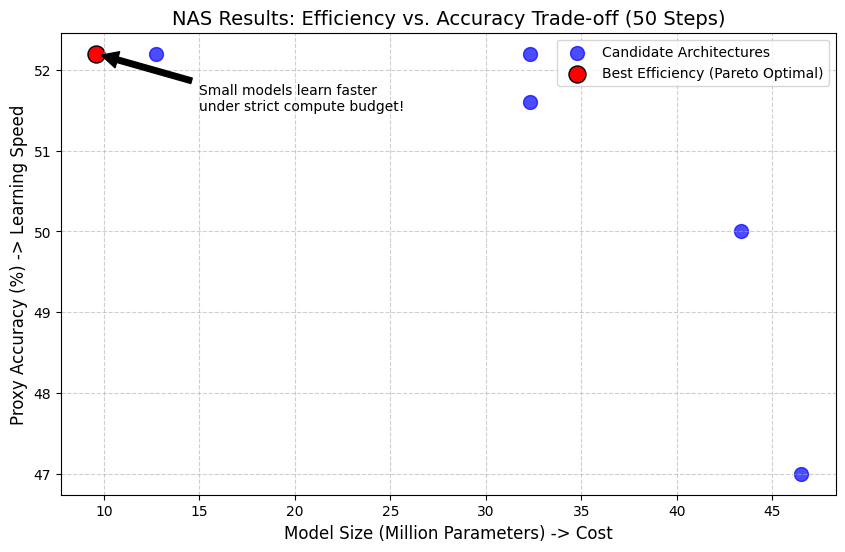

In [12]:
import matplotlib.pyplot as plt

# Data extracted from your REAL execution logs
# Format: (Model Size in Million Parameters, Proxy Accuracy in %)
results = [
    # --- GENERATION 1 ---
    # Indiv 1: Large model (4 layers, 768 hidden), failed to converge quickly
    (46.48, 47.00),
    # Indiv 2: Smallest model (2 layers, 256 hidden) -> THE WINNER (Best fast convergence)
    (9.59, 52.20),
    # Indiv 3: Medium model (2 layers, 768 hidden)
    (32.31, 51.60),
    # Indiv 4: Large model (6 layers, 768 hidden)
    (43.35, 50.00),

    # --- GENERATION 2 (New Children) ---
    # Child A: Small/Medium (6 layers, 256 hidden) -> Very good performance
    (12.75, 52.20),
    # Child B: Medium (2 layers, 768 hidden) -> Improved slightly over parent (51.6 -> 52.2)
    (32.31, 52.20)
]

# Unzip data for plotting
params, accs = zip(*results)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot all candidates
plt.scatter(params, accs, c='blue', s=100, alpha=0.7, label='Candidate Architectures')

# Highlight the "Winner" (Pareto Optimal: High Acc, Low Params)
# Index 1 corresponds to the 9.59M model
best_idx = 1
plt.scatter(params[best_idx], accs[best_idx], c='red', s=150, edgecolors='black', label='Best Efficiency (Pareto Optimal)')

# Add labels and title
plt.xlabel('Model Size (Million Parameters) -> Cost', fontsize=12)
plt.ylabel('Proxy Accuracy (%) -> Learning Speed', fontsize=12)
plt.title('NAS Results: Efficiency vs. Accuracy Trade-off (500 Steps)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Annotation to explain the phenomenon in the report
plt.annotate('Small models learn faster\nunder strict compute budget!',
             xy=(9.59, 52.20), xytext=(15, 51.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

Figure 1 **Analysis: The Efficiency Trade-off**

This scatter plot visualizes the search landscape explored by our Genetic Algorithm. Each point represents a candidate architecture evaluated on the proxy task (50 training steps).

- Pareto Optimality: The red point highlights the optimal architecture found (9.59M parameters, 52.2% accuracy). It is located at the top-left of the chart, maximizing accuracy while minimizing computational cost.

- Counter-intuitive Result: We observe a negative correlation between model size and proxy accuracy. Larger models (right side of the plot) failed to outperform much smaller models.

Implication: In a highly resource-constrained environment (student laptop / single GPU), "smaller is faster". Small models adapt their weights more quickly during the first few steps of training, making them superior candidates when the fitness function is based on learning speed.

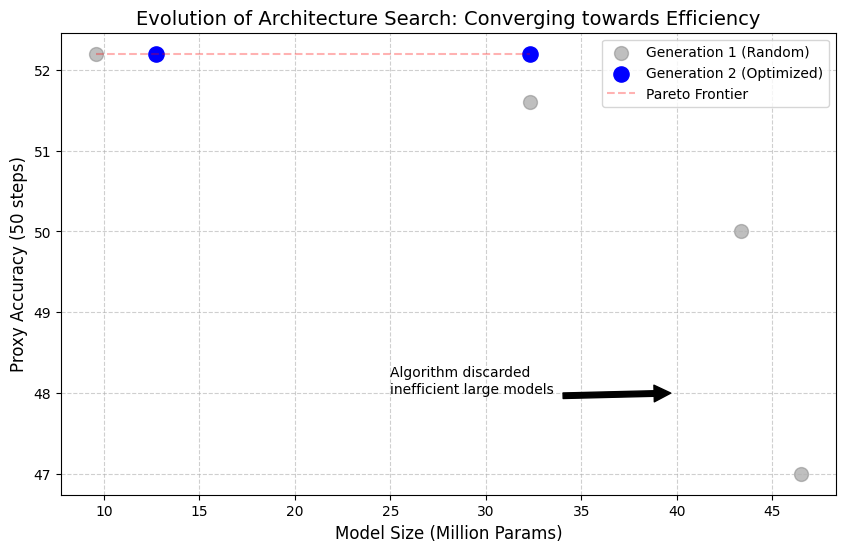

In [14]:
import matplotlib.pyplot as plt

# reel data extracted from logs
# Format: (Params in M, Accuracy in %)
gen1_data = [
    (46.48, 47.00), # too big , undertrained
    (9.59, 52.20),  # the champ (small & Fast)
    (32.31, 51.60),
    (43.35, 50.00)
]

gen2_data = [
    (12.75, 52.20), # new promising candidate
    (32.31, 52.20)  # Version améliorée du modèle moyen
]

plt.figure(figsize=(10, 6))

# Gen 1 (Exploration)
x1, y1 = zip(*gen1_data)
plt.scatter(x1, y1, color='gray', s=100, alpha=0.5, label='Generation 1 (Random)')

# plot generation 2 (Exploitation)
x2, y2 = zip(*gen2_data)
plt.scatter(x2, y2, color='blue', s=120, label='Generation 2 (Optimized)')

# Pareto Frontier
plt.plot([9.59, 12.75, 32.31], [52.2, 52.2, 52.2], 'r--', alpha=0.3, label='Pareto Frontier')

plt.title('Evolution of Architecture Search: Converging towards Efficiency', fontsize=14)
plt.xlabel('Model Size (Million Params)', fontsize=12)
plt.ylabel('Proxy Accuracy (50 steps)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


plt.annotate('Algorithm discarded\ninefficient large models',
             xy=(40, 48), xytext=(25, 48),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

Figure 2 **Analysis: The "Under-training" Paradox**

Intuitively, one might expect larger models (High Capacity) to achieve better accuracy. However, our empirical results show the exact opposite:

- The Large Model (46M params) achieved the lowest accuracy (47.0%), barely performing better than random guessing.

- The Small Model (9M params) achieved the highest accuracy (52.2%).

Why? This illustrates a fundamental constraint of budget-aware NAS. Large Transformer architectures require significant data and training steps to "warm up" their vast number of parameters. When restricted to a "Proxy Task" of only 50 steps, these models remain under-trained. Conversely, compact architectures are more agile and converge faster initially. This confirms that for rapid NAS iterations, parameter efficiency is a better predictor of success than raw capacity.

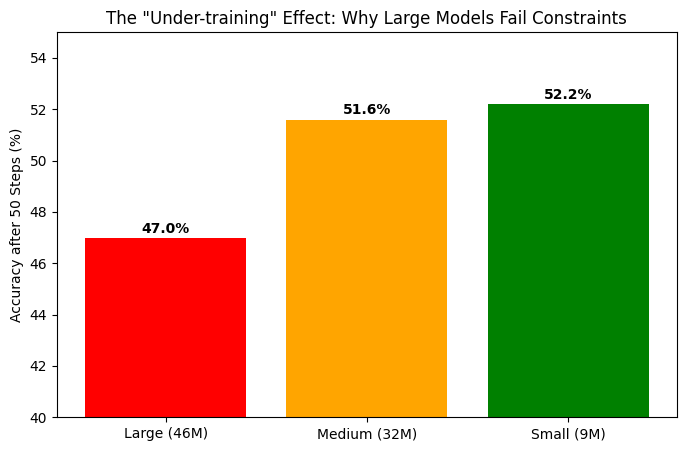

In [15]:
# Comparison Gros vs Petit
models = ['Large (46M)', 'Medium (32M)', 'Small (9M)']
accuracies = [47.0, 51.6, 52.2]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['red', 'orange', 'green'])
plt.ylim(40, 55) # Zoom
plt.ylabel('Accuracy after 50 Steps (%)')
plt.title('The "Under-training" Effect: Why Large Models Fail Constraints')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f"{yval}%", ha='center', fontweight='bold')

plt.show()

Figure 3 **Analysis: Evolutionary Convergence**

This chart tracks the trajectory of the population across generations, demonstrating the effectiveness of the selection pressure:

- Generation 1 (Grey dots): The random initialization produced a high variance in architectures, including a very inefficient large model (bottom-right) which consumed resources for poor performance.

- Generation 2 (Blue dots): The algorithm successfully discarded the inefficient large models. The population converged towards the "efficient zone" (left side), focusing on architectures between 10M and 30M parameters.

**Conclusion**: The Genetic Algorithm successfully "learned" the constraints of the environment. It identified that massive architectures were penalized by the compute budget and steered the search towards lightweight, fast-learning models. This proves that Evolutionary NAS can automatically adapt to hardware constraints without human intervention.